<a href="https://colab.research.google.com/github/candle16/statcan-crime-analysis/blob/cre/crime_analysis_canada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# ============================================================
# CELL 1: Git Setup and Repository Clone
# ============================================================

# Configure Git with your info
!git config --global user.name "candle16"
!git config --global user.email "kateskipton@gmail.com"

# Store credentials so you don't have to enter token every time
!git config --global credential.helper store

# Clone your repository
!git clone https://github.com/candle16/statcan-crime-analysis.git

# Navigate into the folder
%cd statcan-crime-analysis

# Check that you're in the right place
!pwd



Cloning into 'statcan-crime-analysis'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 14 (delta 2), reused 3 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (14/14), 10.85 KiB | 10.85 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/content/statcan-crime-analysis/statcan-crime-analysis
/content/statcan-crime-analysis/statcan-crime-analysis


In [16]:
# CELL 2: Install Dependencies and Fetch Data

import pandas as pd
import matplotlib.pyplot as plt
import requests
import zipfile
from io import BytesIO

# Define the table PID
pid = '35100026'

# Fetch the download URL from the API
api_url = f"https://www150.statcan.gc.ca/t1/wds/rest/getFullTableDownloadCSV/{pid}/en"
response = requests.get(api_url)

if not response.ok:
    raise ValueError(f"API request failed: {response.status_code} - {response.text}")

zip_url = response.json()['object']

# Download the ZIP file
zip_response = requests.get(zip_url)

if not zip_response.ok:
    raise ValueError(f"Data download failed: {zip_response.status_code} - {zip_response.text}")

# Extract and load the CSV
with zipfile.ZipFile(BytesIO(zip_response.content)) as z:
    csv_filename = f"{pid.replace('-', '')}.csv"
    if csv_filename not in z.namelist():
        raise ValueError("CSV file not found in ZIP")
    df = pd.read_csv(z.open(csv_filename), low_memory=False)

print("Data loaded successfully.")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Data loaded successfully.
Shape: (22908, 15)
Columns: ['REF_DATE', 'GEO', 'DGUID', 'Statistics', 'UOM', 'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE', 'VALUE', 'STATUS', 'SYMBOL', 'TERMINATED', 'DECIMALS']


In [19]:
# ============================================================
# CELL 3: Filter and Process Data
# ============================================================

# Filter for Canada and relevant indices
df_filtered = df[(df['GEO'] == 'Canada') &
                 (df['Statistics'].isin(['Crime severity index',
                                                   'Violent crime severity index',
                                                   'Non-violent crime severity index']))]

# Pivot the data for plotting
pivot_df = df_filtered.pivot(index='REF_DATE',
                              columns='Statistics',
                              values='VALUE').reset_index()

# Ensure data covers 1998-2024
available_years = pivot_df['REF_DATE'].unique()
print(f"Available years: {sorted(available_years)}")

if not all(year in available_years for year in range(1998, 2025)):
    print("Warning: Data does not cover the full range from 1998 to 2024")
    print(f"Missing years: {set(range(1998, 2025)) - set(available_years)}")

print(f"\nData preview:")
print(pivot_df.head())
print(f"\nData shape: {pivot_df.shape}")

Available years: [np.int64(1998), np.int64(1999), np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]

Data preview:
Statistics  REF_DATE  Crime severity index  Non-violent crime severity index  \
0               1998                118.84                            126.93   
1               1999                111.24                            115.80   
2               2000                106.73                            110.17   
3               2001                105.30                            108.41   
4               2002                104.14                            107.19   

Statistics  Violent crime severity index  
0          

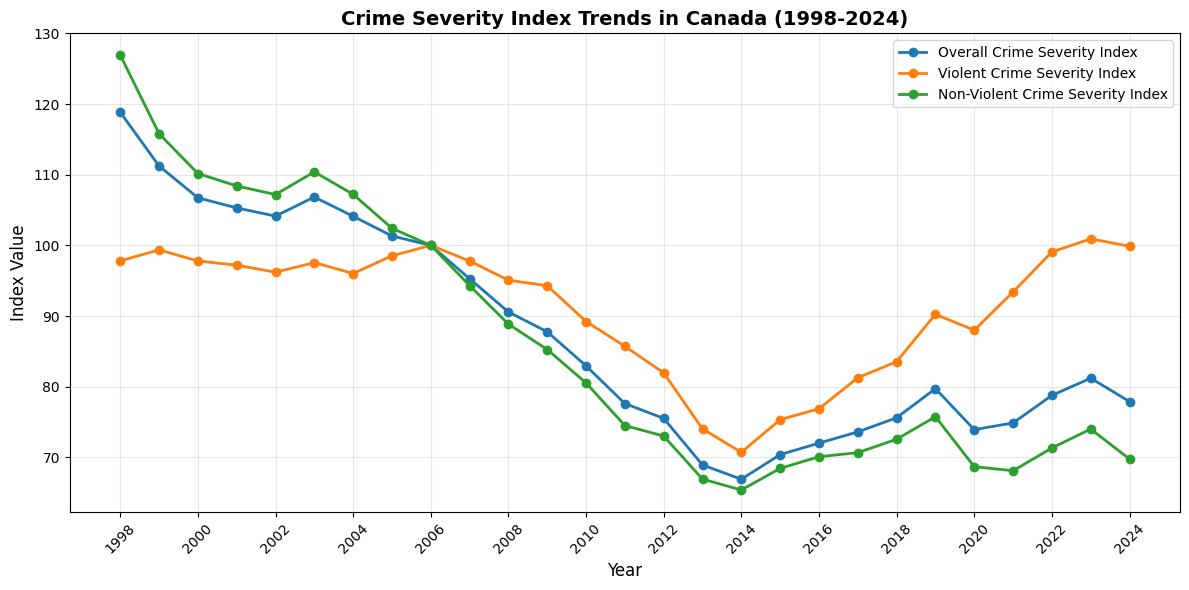

In [20]:

# ============================================================
# CELL 4: Create Visualization
# ============================================================

# Plot the line graph
plt.figure(figsize=(12, 6))
plt.plot(pivot_df['REF_DATE'], pivot_df['Crime severity index'],
         label='Overall Crime Severity Index', marker='o', linewidth=2)
plt.plot(pivot_df['REF_DATE'], pivot_df['Violent crime severity index'],
         label='Violent Crime Severity Index', marker='o', linewidth=2)
plt.plot(pivot_df['REF_DATE'], pivot_df['Non-violent crime severity index'],
         label='Non-Violent Crime Severity Index', marker='o', linewidth=2)

plt.title('Crime Severity Index Trends in Canada (1998-2024)', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Index Value', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.xticks(range(1998, 2025, 2), rotation=45)
plt.tight_layout()
plt.show()



In [23]:

# ============================================================
# CELL 5: Calculate Growth Rates
# ============================================================

# Extract values for 2019 and 2024
df_2019 = pivot_df[pivot_df['REF_DATE'] == 2019].set_index('REF_DATE')
df_2024 = pivot_df[pivot_df['REF_DATE'] == 2024].set_index('REF_DATE')

if df_2019.empty:
    print("Warning: No data available for 2019")
if df_2024.empty:
    print("Warning: No data available for 2024")

if not df_2019.empty and not df_2024.empty:
    # Calculate growth rates using iloc[0] to access the single row of values
    growth_rates = ((df_2024.iloc[0] - df_2019.iloc[0]) / df_2019.iloc[0] * 100).round(2)

    # Convert the resulting Series to a DataFrame with the desired column name
    growth_rates = growth_rates.to_frame(name='Growth Rate 2019-2024 (%)')

    # Display as a table
    print("\nGrowth Rates from 2019 to 2024:")
    print(growth_rates)
    print("\n" + "="*50)

    # Also display the actual values for context
    print("\n2019 Values:")
    print(df_2019.T)
    print("\n2024 Values:")
    print(df_2024.T)
else:
    print("Cannot calculate growth rates - missing data for 2019 or 2024")


Growth Rates from 2019 to 2024:
                                  Growth Rate 2019-2024 (%)
Statistics                                                 
Crime severity index                                  -2.30
Non-violent crime severity index                      -7.91
Violent crime severity index                          10.67


2019 Values:
REF_DATE                           2019
Statistics                             
Crime severity index              79.72
Non-violent crime severity index  75.75
Violent crime severity index      90.24

2024 Values:
REF_DATE                           2024
Statistics                             
Crime severity index              77.89
Non-violent crime severity index  69.76
Violent crime severity index      99.87
